## A dynamic learning approach that progressively expands the network by incorporating additional neurons solely for task learning purposes, thereby freezing the weights of existing neurons during back-propagation.

#### Importing libraries and dataset

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

# resize and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size * image_size])
x_test = np.reshape(x_test,[-1, image_size* image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


#### Creating tasks

In [2]:
import numpy as np
import pickle

np.random.seed(100)
n_tasks = 5

from keras.utils import np_utils

task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[8,9], [6,7], [4,5], [3,2], [1,0]]
#task_labels = [[0,1], [4,5], [6,7], [8,9], [2,3]]
#task_labels = [[4,2], [0,6], [3,8], [9,7], [1,5],[8,9],[6,7],[5,5],[3,2],[0,1]]
#task_labels = [[16,14], [25, 7], [20, 27], [15, 1], [32, 19]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[9, 3], [1, 8], [7, 4], [0, 5], [6, 2]]
#task_labels = [[0,1], [2,3,1,0],[4,5,1,2], [6,7,3,0],[8,9,4,6]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_train[idx], np_utils.to_categorical(label_map[y_train[idx]], len(labels))
    else:
        data = x_train[idx], np_utils.to_categorical(y_train[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(y_test, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_test[idx], np_utils.to_categorical(label_map[y_test[idx]], len(labels))
    else:
        data = x_test[idx], np_utils.to_categorical(y_test[idx], nb_classes)
        validation_datasets.append(data)
        
tasks_train={}; labels_train = {}; tasks_test = {}; labels_test = {}

for i in range(len(task_labels)):
    tasks_train[str(i)] = training_datasets[i][0]
    labels_train[str(i)] = training_datasets[i][1]
    tasks_test[str(i)] = validation_datasets[i][0]
    labels_test[str(i)] = validation_datasets[i][1]
    print('Task {0} size: Trainset - {1}, {2}, Testset - {3}, {4}'.format(i,tasks_train[str(i)].shape, labels_train[str(i)].shape, tasks_test[str(i)].shape, labels_test[str(i)].shape))

Tasks_dumped = []
for i in range(len(task_labels)):
    Tasks_dumped.append((tasks_train[str(i)], labels_train[str(i)], tasks_test[str(i)], labels_test[str(i)], tasks_test[str(i)], labels_test[str(i)]))
f = open('mnist_tasks.pkl', "wb")
pickle.dump(Tasks_dumped, f)
f.close()

Task 0 size: Trainset - (12665, 784), (12665, 10), Testset - (2115, 784), (2115, 10)
Task 1 size: Trainset - (12089, 784), (12089, 10), Testset - (2042, 784), (2042, 10)
Task 2 size: Trainset - (11263, 784), (11263, 10), Testset - (1874, 784), (1874, 10)
Task 3 size: Trainset - (12183, 784), (12183, 10), Testset - (1986, 784), (1986, 10)
Task 4 size: Trainset - (11800, 784), (11800, 10), Testset - (1983, 784), (1983, 10)


#### Training the progressive learning model.

In [3]:
def create_model(learning_rate, dense_1, dense_2):
    assert learning_rate > 0 and dense_1 > 0 and dense_2 > 0, "Did you set the right configuration?"
    model = Sequential()
    model.add(Dense(int(dense_1), input_shape=(784,), activation='relu', name='fc1'))
    model.add(Dense(int(dense_2), activation='relu', name='fc2'))
    model.add(Dense(10, activation='softmax', name='output'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

import pickle
import pdb
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import save_model
from keras.models import load_model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            layer_weights[0][:last_model_stats['weights'][-1][2*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][2*i]
            layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][2*i+1]
            model.layers[i].set_weights(layer_weights)      

    def on_batch_end(self, batch, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            #pdb.set_trace()
            layer_weights[0][:last_model_stats['weights'][-1][2*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][2*i]
            layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][2*i+1]
            model.layers[i].set_weights(layer_weights)
        
def create_task(data_path):
    data = pickle.load(open(data_path, "rb"))
    return data

task_list = create_task('mnist_tasks.pkl')
num_tasks=5
Model_Perf_save = {}
Model_Perf_save['acc'] = []
Model_Perf_save['shape'] = []
Model_Perf_save['weights'] = []
for task_id in range(num_tasks):
    print(f'----Learning task {task_id+1}: classification between labels {task_labels[task_id]}.----')
    f = open('task_dataset.pkl', 'wb')
    pickle.dump(task_list[task_id], f)
    f.close()
    if task_id == 0:
        model = create_model(learning_rate=0.01, dense_1=50, dense_2=50)
        #call one of the search algorithm
        history = model.fit(task_list[task_id][0], task_list[task_id][1],
              batch_size=128, epochs=10, verbose=0,
              validation_data=(task_list[task_id][2], task_list[task_id][3]))
    else:
        dense_1 = 50 + Model_Perf_save['shape'][-1][1][0]
        dense_2 = 50 + Model_Perf_save['shape'][-1][3][0]
        model = create_model(learning_rate=0.01, dense_1=dense_1, dense_2=dense_2)
        history = model.fit(task_list[task_id][0], task_list[task_id][1],
              batch_size=128, epochs=10, verbose=0,
              validation_data=(task_list[task_id][2], task_list[task_id][3]), callbacks  = [LossHistory()])
    save_model(model, f'tasks_{task_id+1}_model.h5')
    loss_and_metrics = model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=2)
    Model_Perf_save['acc'].append(loss_and_metrics[1])
    Model_Perf_save['shape'].append([i.shape for i in model.get_weights()])
    Model_Perf_save['weights'].append(model.get_weights()) 

----Learning task 1: classification between labels [0, 1].----
67/67 - 0s - loss: 0.0030 - accuracy: 0.9991 - 47ms/epoch - 701us/step
----Learning task 2: classification between labels [2, 3].----
64/64 - 0s - loss: 0.0242 - accuracy: 0.9931 - 63ms/epoch - 987us/step
----Learning task 3: classification between labels [4, 5].----
59/59 - 0s - loss: 0.0045 - accuracy: 0.9984 - 63ms/epoch - 1ms/step
----Learning task 4: classification between labels [6, 7].----
63/63 - 0s - loss: 0.0222 - accuracy: 0.9985 - 79ms/epoch - 1ms/step
----Learning task 5: classification between labels [8, 9].----
62/62 - 0s - loss: 0.0424 - accuracy: 0.9869 - 63ms/epoch - 1ms/step


In [4]:
Model_Perf_save['acc']

[0.9990543723106384,
 0.9931439757347107,
 0.9983991384506226,
 0.9984894394874573,
 0.9868885278701782]

#### Verify above accuracy from the loded model.

In [5]:
learn_accuracy = []
for task_id in range(num_tasks):
    # Load the model
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
    learn_accuracy.append(result)
    print(f'Task {task_id+1} accuracy: {result}') 

Task 1 accuracy: 0.9990543723106384
Task 2 accuracy: 0.9931439757347107
Task 3 accuracy: 0.9983991384506226
Task 4 accuracy: 0.9984894394874573
Task 5 accuracy: 0.9868885278701782


#### Checking sparsity before unlearning.

In [6]:
# Function to calculate sparsity
def calculate_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights = layer.get_weights()
            if weights:
                for weight in weights:
                    total_weights += np.prod(weight.shape)
                    zero_weights += np.sum(weight == 0)
    return zero_weights / total_weights

print('Sparsity of the model before unlearning:', "{:.10f}".format(calculate_sparsity(model)) )

Sparsity of the model before unlearning: 0.0000688310


#### Forgetting task 2 : task that does classification between [2,3].

#### Randomizing weights only at output layer.

In [7]:
def replace_with_random(array):
    """
    Replace elements in the array with random values while preserving the distribution.

    Args:
    array: NumPy array containing floating-point values.

    Returns:
    NumPy array with elements replaced by random values.
    """
    # Compute the mean and standard deviation of the original array
    mean = 1-np.mean(array)
    std_dev = 1+np.std(array)

    # Generate random values with the same distribution as the original array
    random_values = np.random.normal(mean, std_dev, array.shape)

    return random_values

In [8]:
forget_task=2
forget_T2_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T2_acc.append(result)
        print(f'Forget task accuracy: {result}') 

Forget task accuracy: 0.5053868889808655


An accuracy rate of 50% in the forget task is considered complete forgetting. This occurs because it's a binary classification task, and when the output consistently remains zero, it effectively represents one valid outcome for 50% of the inference dataset. It's important to note that in each task, the classes are either 0 or 1, and resetting the weights to zero consistently results in an output value of zero, which is a valid outcome for one of the classes.


It's worth mentioning that the accuracy for the forget task doesn't precisely reach 50% due to a partial misalignment in the dimensionality of the inference dataset between the two classes.

#### Randomizing weights at the hidden layers as well as output layer.

In [9]:
forget_task=2
forget_T2_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            else:
                if task_id == forget_task-1:
                    zero_weight_location = Model_Perf_save['shape'][task_id-1][2*k]
                    weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:] = replace_with_random(weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:])
                    zero_bias_location = Model_Perf_save['shape'][task_id-1][2*k+1]
                    biases[zero_bias_location[0]:] = replace_with_random(biases[zero_bias_location[0]:])
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T2_acc.append(result)
        print(f'Forget task accuracy: {result}') 

Forget task accuracy: 0.4946131110191345


In [10]:
print('Sparsity of the model after unlearning task 2:', "{:.10f}".format(calculate_sparsity(loaded_model)) )

Sparsity of the model after unlearning task 2: 0.0000688310


Impact is minimal on other tasks when zeroing the hidden layer weights. 

#### Forgetting task 3 : task that does classification between [4,5].

In [11]:
forget_task=3
forget_T3_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            else:
                if task_id == forget_task-1:
                    zero_weight_location = Model_Perf_save['shape'][task_id-1][2*k]
                    weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:] = replace_with_random(weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:])
                    zero_bias_location = Model_Perf_save['shape'][task_id-1][2*k+1]
                    biases[zero_bias_location[0]:] = replace_with_random(biases[zero_bias_location[0]:])
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T3_acc.append(result)
        print(f'Forget task accuracy: {result}') 

Forget task accuracy: 0.47598719596862793


In [12]:
print('Sparsity of the model after unlearning task 3:', "{:.10f}".format(calculate_sparsity(loaded_model)) )

Sparsity of the model after unlearning task 3: 0.0000688310


#### Forgetting task 4 : task that does classification between [6,7].

In [13]:
forget_task=4
forget_T4_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            else:
                if task_id == forget_task-1:
                    zero_weight_location = Model_Perf_save['shape'][task_id-1][2*k]
                    weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:] = replace_with_random(weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:])
                    zero_bias_location = Model_Perf_save['shape'][task_id-1][2*k+1]
                    biases[zero_bias_location[0]:] = replace_with_random(biases[zero_bias_location[0]:])
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T4_acc.append(result)
        print(f'Forget task accuracy: {result}')          

Forget task accuracy: 0.4823766350746155


In [14]:
print('Sparsity of the model after unlearning task 4:', "{:.10f}".format(calculate_sparsity(loaded_model)) )

Sparsity of the model after unlearning task 4: 0.0000688310


#### Forgetting task 5 : task that does classification between [8,9].

In [15]:
forget_task=5
forget_T5_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            else:
                if task_id == forget_task-1:
                    zero_weight_location = Model_Perf_save['shape'][task_id-1][2*k]
                    weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:] = replace_with_random(weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:])
                    zero_bias_location = Model_Perf_save['shape'][task_id-1][2*k+1]
                    biases[zero_bias_location[0]:] = replace_with_random(biases[zero_bias_location[0]:])
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T5_acc.append(result)
        print(f'Forget task accuracy: {result}')          

Forget task accuracy: 0.5088250041007996


In [16]:
print('Sparsity of the model after unlearning task 5:', "{:.10f}".format(calculate_sparsity(loaded_model)) )

Sparsity of the model after unlearning task 5: 0.0000344155


#### Forgetting task 1 (very first task) : task that does classification between [0,1].

In [17]:
forget_task=1
forget_T1_acc = []
class_to_forget = task_labels[forget_task-1]
#Zero out the weights corresponding to this class
for task_id in range(num_tasks):
    loaded_model = load_model(f'tasks_{task_id+1}_model.h5')
    for k,layer in enumerate(loaded_model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == loaded_model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = replace_with_random(weights[:, cl]) # random out weights for the forgotten class in the output layer
                    biases[cl] = replace_with_random(biases[cl]) # random out weights for the forgotten class in the output
            else:
                if task_id < forget_task-1:
                    pass
                else:
                    if task_id == 0:
                        zero_weight_location = Model_Perf_save['shape'][task_id][2*k]
                        weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:] = replace_with_random(weights[zero_weight_location[0]-1:, zero_weight_location[1]-1:])
                        zero_bias_location = Model_Perf_save['shape'][task_id-1][2*k+1]
                        biases[zero_bias_location[0]:] = replace_with_random(biases[zero_bias_location[0]:])
                    else:
                        pass
            layer.set_weights([weights, biases])
    if task_id == forget_task-1:
        result = loaded_model.evaluate(task_list[task_id][4], task_list[task_id][5], verbose=0)[1]
        forget_T1_acc.append(result)
        print(f'Forget task accuracy: {result}') 

C:\Users\rrk307\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rrk307\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rrk307\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rrk307\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\rrk307\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Forget task accuracy: 0.46335697174072266


In [18]:
print('Sparsity of the model after unlearning task 1:', "{:.10f}".format(calculate_sparsity(loaded_model)) )

Sparsity of the model after unlearning task 1: 0.0000688310


In [19]:
print(forget_T1_acc, '\n', forget_T2_acc, '\n', forget_T3_acc, '\n', forget_T4_acc, '\n', forget_T5_acc, '\n', learn_accuracy )

[0.46335697174072266] 
 [0.4946131110191345] 
 [0.47598719596862793] 
 [0.4823766350746155] 
 [0.5088250041007996] 
 [0.9990543723106384, 0.9931439757347107, 0.9983991384506226, 0.9984894394874573, 0.9868885278701782]


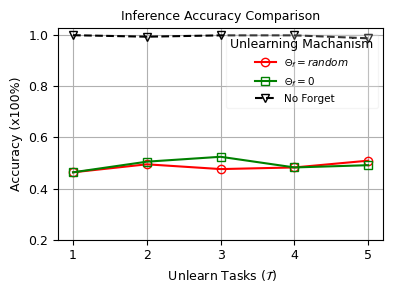

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
plt.figure(figsize=(4, 3))
mpl.rcParams['font.size'] = 9

# Plotting the lists
plt.plot(np.arange(1, 6), [forget_T1_acc[0], forget_T2_acc[0], forget_T3_acc[0], forget_T4_acc[0], forget_T5_acc[0]], label='$\mathcal{\Theta}_f=random$', marker='o', color='r', fillstyle = 'none')
plt.plot(np.arange(1, 6), [0.46335697174072266, 0.5048971772193909, 0.5240128040313721, 0.4823766350746155, 0.49117499589920044], label='$\mathcal{\Theta}_f=0$', marker='s', color='g', fillstyle = 'none')
plt.plot(np.arange(1, 6), learn_accuracy, label='No Forget', linestyle='--', color='black', marker='v', fillstyle = 'none')

# Adding labels and title
plt.xlabel(' Unlearn Tasks ($\mathcal{T}$)')
plt.ylabel('Accuracy (x100%)')
plt.title('Inference Accuracy Comparison', fontsize = 9)

# Adding grid
plt.grid(True)

# Setting x-axis ticks
plt.xticks(np.arange(1, 6))
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])

# Adding legend
plt.legend(title='Unlearning Machanism', loc='upper right', ncol=1,  fontsize='small', framealpha=0.2)

plt.tight_layout()
plt.savefig('Dynamic_random.pdf')
# Displaying the plot
plt.show()
